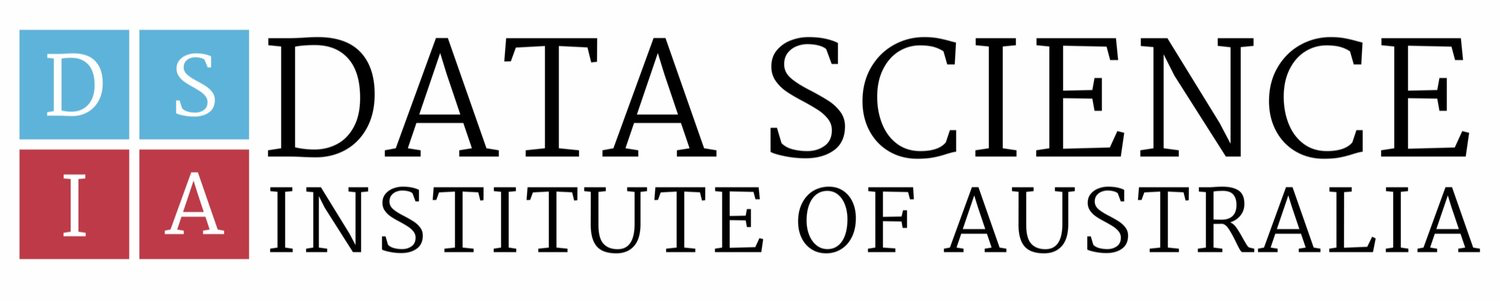

# Data Science and AI
## Lab 5.4: Bayesian Inference
### Part 1: Bayesian Modelling
In this example, a new campaign results in _seven_ clicks from _ten_ trial subjects. We have prior information from a large number of campaigns that did not perform nearly this well, so we are not prepared to accept that our raw experimental click-through rate of _0.7_ is predictive of the future success of the new campaign.

If we had a much larger sample from the trial, we would have more confidence in the result. As it stands, we must view our trial as a small sample of the true click-through rate population (which follows an unknown distribution), and regard the result of _0.7_ with suspicion that it is a statistical anomaly.

Fortunately, we can use Bayesian modelling to revise the predicted click-through rate for the campaign down to something more believable, based on our prior information.

Reference: [Introduction to Bayesian Inference-Learn data science tutorials](https://www.datascience.com/blog/introduction-to-bayesian-inference-learn-data-science-tutorials)

INSTRUCTIONS:

- Run the cells
- Observe and understand the results
- Answer the questions

In [1]:
pip install pymc3

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import factorial
from scipy.stats import beta
import pymc3 as pm

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\anjoa\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


A subject will either click (True) or not (False), so we need a binomial distribution with a success probability **theta**:

$$ y = {n! \over x! \; (n - x)!} \cdot \theta^x \cdot (1 - \theta)^{n - x} $$

In [3]:
def likelihood(theta, n, x):
    '''
    likelihood function for a binomial distribution

    n: [int] the number of experiments
    x: [int] the number of successes
    theta: [float] the proposed probability of success
    '''
    y = (factorial(n) / (factorial(x) * factorial(n - x))) * \
        (theta ** x) * ((1 - theta) ** (n - x))
    return y

Here, we enter our test results and compute our assumed probability distribution for every possible binomial outcome:

In [4]:
n_impressions = 10  # number of impressions in the trial
n_clicks = 7  # number of click-throughsin the trial
ctr = n_clicks / n_impressions  # observed click-through rate

# to get a distribution, we let theta range over all
# possible click-through rates:
theta_range = np.arange(0, 1, 0.01)
# then evaluate the likelihood function for possible click-through rates:
likelihoods = [likelihood(theta, n_impressions, n_clicks)
               for theta in theta_range]

# peak theta (i.e. theta value at which the likelihood is maximal):
mle = theta_range[np.argmax(likelihoods)]
print('Maximum likelihood: %.2f' % mle)

Maximum likelihood: 0.70


The above result confirms that _0.7_ is the most likely outcome of the test sample.

Formally, we state this using the `argmax` function, which returns value of the argument that yields the maximimum value of the function:

$$ argmax_\theta \; [p(X|\theta)] = 0.7 $$

In our case, $\theta$ (_theta_) in this the argument and X is the sample data.

Now, let's plot the distribution of likelihood:

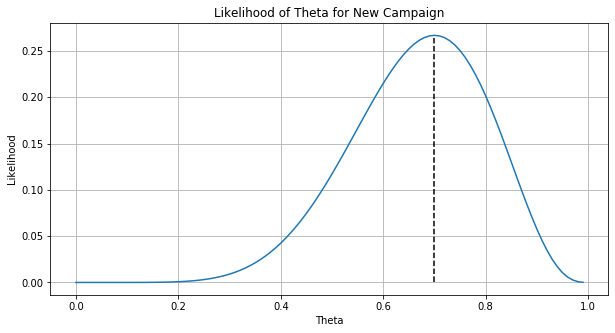

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(theta_range, likelihoods)
plt.vlines(mle, 0, max(likelihoods), linestyle='--')
plt.title('Likelihood of Theta for New Campaign')
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.grid()
plt.show()

The prior data (100 previous campaigns) are simulated below:

In [6]:
# fake data:
true_a = 11.5  # alpha argument of binomial pdf
true_b = 48.5  # beta argument of binomial pdf
N = 100        # number of previous marketing campaigns
# randomly generated "true" click-through rates (one for each campaign)
p = np.random.beta(true_a, true_b, size=N)
# randomly generated number of impressions (one for each campaign)
impressions = np.random.randint(1, 10000, size=N)
# sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p)
click_through_rates = clicks / impressions

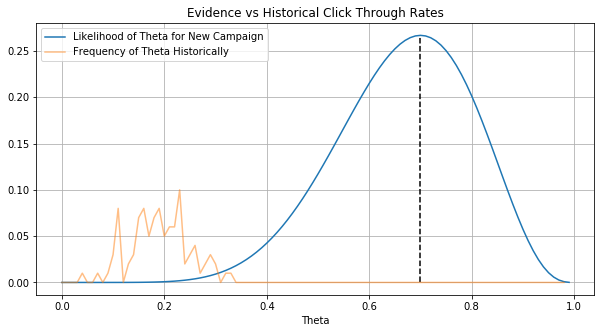

In [7]:
# plot the histogram of previous click through rates with the evidence
# of the new campaign:
plt.figure(figsize=(10, 5))
plt.vlines(mle, 0, max(likelihoods), linestyle='--')
plt.plot(theta_range,
         likelihoods,
         label='Likelihood of Theta for New Campaign')
zero_to_one = np.arange(0, 1, 0.01)
counts, bins = np.histogram(click_through_rates, bins=zero_to_one)
counts = counts / 100
plt.plot(bins[:-1],
         counts,
         alpha=0.5,
         label='Frequency of Theta Historically')
plt.legend(loc='upper left')
plt.xlabel('Theta')
plt.grid()
plt.title('Evidence vs Historical Click Through Rates')
plt.show()

Clearly, the test of the new campaign is predicting an improbably high click-through rate, based on past experience.

Now we need to choose a prior distribution for modelling our prior data. For binomial problems like this, the beta distribution is preferred. We can compute the two parameters of the beta function that fits our data using the `beta` library:

In [8]:
prior_parameters = beta.fit(click_through_rates, floc=0, fscale=1)
prior_a, prior_b = prior_parameters[0:2]
print(prior_a, prior_b)

8.557911243091887 35.12676709595831


### Question
- Why the values above are not equal to `true_a` and `true_b` , which we used to construct the fake data in the first place?

### Answer
- ?
- ?

In [9]:
# define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)
# get histogram of samples
prior_samples = prior_distribution.rvs(10000)
raw_fit_counts, bins = np.histogram(prior_samples, zero_to_one)
# normalise histogram
fit_counts = raw_fit_counts / raw_fit_counts.sum()

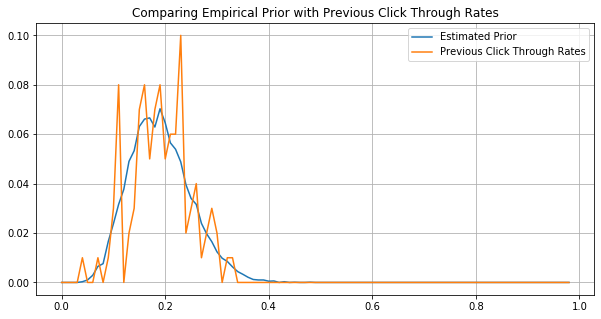

In [10]:
# plot
plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], fit_counts,
         label='Estimated Prior')
raw_hist_ctr, bins = np.histogram(click_through_rates, zero_to_one)
hist_ctr = raw_hist_ctr / raw_hist_ctr.sum()
plt.plot(bins[:-1], hist_ctr,
         label='Previous Click Through Rates')
plt.legend()
plt.grid()
plt.title('Comparing Empirical Prior with Previous Click Through Rates')
plt.show()

So, we have a prior distribution that fits the historical data well. We can now use this to revise our belief in the latest test data, which means we need to solve for the posterior distribution.

This kind of statistical modelling problem is often tackled by simulation. One method is called Markov Chain Monte Carlo (MCMC), which generates samples that mimic the unknown distribution. In Python, this is implemented in the PyMC package:

In [11]:
# create our data:clicks = np.array([n_clicks])
# clicks represents our successes.
# We observed 7 clicks.impressions = np.array([n_impressions])
# this represents the number of trials. There were 10 impressions.

with pm.Model() as model:
    theta_prior = pm.Beta('prior',
                          prior_a,
                          prior_b)

    # sampling distribition of outcomes in the dataset:
    observations = pm.Binomial('obs',
                               n=impressions,
                               p=theta_prior,
                               observed=clicks)
    # find good starting values for the sampling algorithm
    start = pm.find_MAP()
    # specify MCMC algorithm: NUTS, the No U-Turn Sampler (Hamiltonian)
    step = pm.NUTS()
    trace = pm.sample(5000,
                      tune=1000,
                      progressbar=True)

logp = -4,054.6, ||grad|| = 1,899.2: 100%|██████████| 6/6 [00:00<00:00, 332.35it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [01:34<00:00, 253.30draws/s]


If the above worked (i.e. if there were no DLL errors from pymc3 dependences), we can now plot the posterior distribution of predicted click-through rates:

In [12]:
# histogram of samples from posterior distribution of CTRs:
posterior_counts, posterior_bins = np.histogram(trace['prior'],
                                                bins=zero_to_one)
# normalised histogram
posterior_counts = posterior_counts / posterior_counts.sum()

# take the mean of the samples as most plausible value:
most_plausible_theta = np.mean(trace['prior'])

# histogram of samples from prior distribution:
prior_counts, bins = np.histogram(prior_samples, bins=zero_to_one)
# normalise
prior_counts = prior_counts / prior_counts.sum()

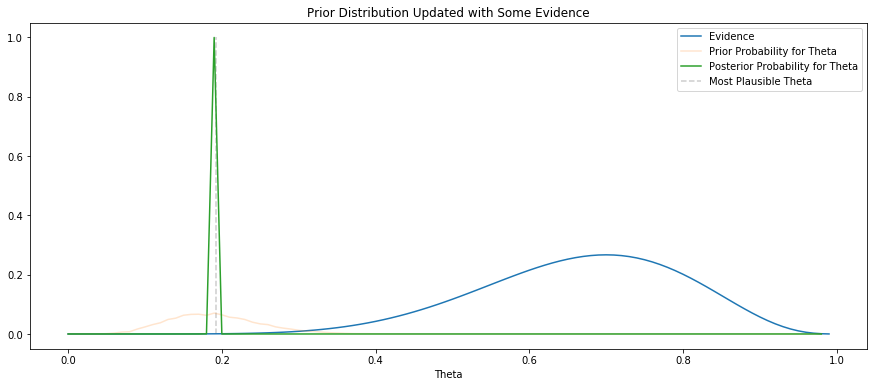

In [13]:
plt.figure(figsize=(15, 6))
plt.plot(theta_range, likelihoods,
         label='Evidence')
plt.plot(bins[:-1], prior_counts, alpha=0.2,
         label='Prior Probability for Theta')
plt.plot(bins[:-1], posterior_counts, label='Posterior Probability for Theta')
m = np.max([max(likelihoods), prior_counts.max(), posterior_counts.max()])
plt.vlines(most_plausible_theta, 0, m, linestyle='--', alpha=0.2,
           label='Most Plausible Theta')
plt.legend(loc='upper right')
plt.xlabel('Theta')
# ax.grid()
plt.title('Prior Distribution Updated with Some Evidence')
plt.show()

So, the dark grey curve is our distribution -- what we believe to be the likely population of click-through rates of the new campaign, based on prior data and our recent trial.

The argmax of this function gives our new most-likely click-through rate = 0.27. This is a lot lower than the sample result of 0.7, but substantially higher than the prior data. So, we believe that the new campaign is an improvement, but we will need more data before we can revise our expectations further up.

### Part 2: Bayesian Classification
In this part we will use the Bayesian approach to building a classifier.

### Titanic Survival
For the first exercise, let's return to the Titanic dataset to see how well we can predict passenger survival using the features as priors.

In [15]:
# prepare data as in previous lab ...
titanic = pd.read_csv('titanic_train.csv', index_col='PassengerId')
ttwd = pd.get_dummies(data=titanic,
                      columns=['Sex', 'Embarked', 'Pclass'],
                      prefix=['Sex', 'Embarked', 'Pclass'])
cols = ['Age', 'Parch', 'Sex_male', 'Pclass_1', 'Pclass_2']
gby = ['Parch', 'Sex_male', 'Pclass_1', 'Pclass_2']
ttwd['Age'] = ttwd[cols].groupby(gby)['Age'] \
    .transform(lambda x: x.fillna(x.mean()))
feature_cols = ['Parch', 'Sex_male', 'Sex_female',
                'Pclass_1', 'Pclass_2', 'Pclass_3',
                'Age', 'SibSp']
X = ttwd[feature_cols]
y = ttwd.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

Nb. the `test_size` parameter determines the size of the test set relative to the combined set:

In [16]:
len(y_train), len(y_test)

(623, 268)

We will first try the **Gaussian Naïve Bayes** classifier:

In [17]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print('accuracy = %.4f' % accuracy_score(y_test, y_pred))

accuracy = 0.7612


For a detailed look at how the Bayesian method actually works, see [sicara.com](https://blog.sicara.com/naive-bayes-classifier-sklearn-python-example-tips-42d100429e44).

**Note**: For simplicity, this example only addresses a single-predictor case, using the `Fare` feature.

Try the **Bernoulli** classifer:

In [22]:
# insert code here
ber =BernoulliNB()
ber.fit(X_train, y_train)
y_pred = ber.predict(X_test)

print('accuracy = %.4f' % accuracy_score(y_test, y_pred))

accuracy = 0.7578


Try the **Multinomial** classifer:

In [23]:
# insert code here
multi = MultinomialNB()
multi.fit(X_train, y_train)
y_pred = multi.predict(X_test)

print('accuracy = %.4f' % accuracy_score(y_test, y_pred))

accuracy = 0.6794


So, it looks like Gaussian was best (actually, the other two are not intended for continuous data) -- but not as good as our logistic regression result.

### Question
- However, we should not try to evaluate models in such a simple way. What should we have done?

### Answer
- ?
- ?
- ?
- ?
- ?

Maybe we are not using the right cut-off value.

By default, we are predicting that `Survival` is True if the probability >= _0.5_, but we could use a different threshold.

The **ROC** curve helps us decide (as well as showing us how good our predictive model really is):

We still have a few features we have not tried. Include them in the model and test again:

In [21]:
feature_cols2 = ['Parch', 'Sex_male', 'Sex_female',
                 'Pclass_1', 'Pclass_2', 'Pclass_3',
                 'Age', 'SibSp', 'Fare',
                 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X = ttwd[feature_cols2]
y = ttwd.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=1)
gnb2 = GaussianNB()
gnb2.fit(X_train, y_train)
y_pred = gnb2.predict(X_test)

print('accuracy = %.4f' % accuracy_score(y_test, y_pred))

accuracy = 0.7713
